Think I have a nice big high-quality dataset now.

Let's start to lay the framework for fine-tuning a DINO model to perform multiclass classification.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# os.path.join(CLIP_FRAMES_FOLDER, LABEL_ENCODER_FILENAME)
# path = '/home/rocus/Documents/john/grepl/clip_frames/label_encoder.pkl'
path = '/home/rocus/Documents/john/grepl/clip_frames/filtered_label_encoder.pkl'

import pickle

label_encoder = pickle.load(open(path, 'rb'))
print(len(label_encoder.classes_))

1067


In [3]:
labels_of_interest = [
    "#butterflyguard",
    "#triangle",
    "#frontheadlock",
    "#legentanglement",
    "#singleleg",
    "#armbar",
    "#submission",
]
labels_of_interest_indices = dict(zip(
    labels_of_interest,
    label_encoder.transform(labels_of_interest).tolist()
))
labels_of_interest_indices

{'#butterflyguard': 132,
 '#triangle': 971,
 '#frontheadlock': 332,
 '#legentanglement': 552,
 '#singleleg': 854,
 '#armbar': 56,
 '#submission': 911}

Video Tensor Size: torch.Size([30, 3, 224, 224])


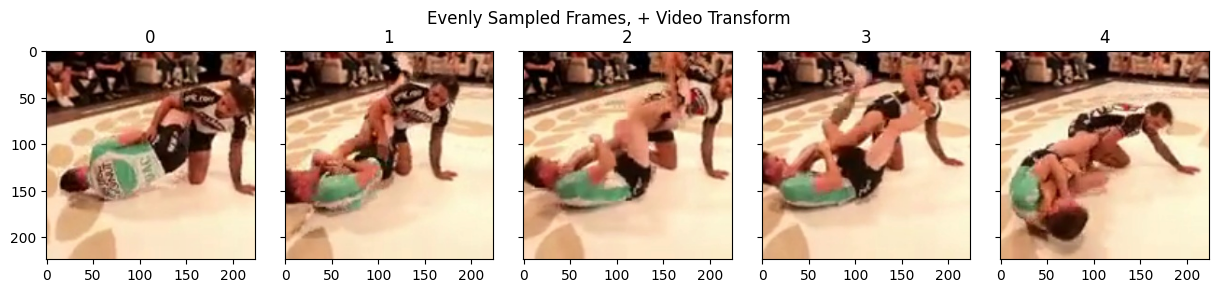

In [4]:
from grepl.processing.generate_annotations import (
    CLIP_FRAMES_FOLDER, ANNOTATION_FILENAME, ANNOTATION_CSV_FILENAME, LABEL_ENCODER_FILENAME
)
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from grepl.processing.videos_to_frames import FILE_TEMPLATE
from grepl.processing.video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

train_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_train.txt")
val_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_valid.txt")
test_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_test.txt")

# label_encoder = pickle.load(open(os.path.join(CLIP_FRAMES_FOLDER, LABEL_ENCODER_FILENAME), 'rb'))

# """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
# dataset = VideoFrameDataset(
#     root_path=CLIP_FRAMES_FOLDER,
#     annotationfile_path=train_annotation_file,
#     num_segments=30,
#     frames_per_segment=1,
#     imagefile_template=FILE_TEMPLATE,
#     transform=None,
#     test_mode=False
# )

# sample = dataset[0]  # take first sample of dataset 
# frames = sample[0]   # list of PIL images
# label = sample[1]    # integer label

# for image in frames:
#     plt.imshow(image)
#     plt.title(label)
#     plt.show()
#     plt.pause(0.1)

# NEW_SIZE = 240  # Resize to this size before center-cropping
NEW_SIZE = 224  # Resize to this size before center-cropping

preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    # resize to 224 and then center-crop, as woctezuma points out: 
    # https://github.com/facebookresearch/dinov2/issues/86#issuecomment-1536019590
    # (this is almost certainly extremely common)
    transforms.Resize(NEW_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(NEW_SIZE),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalization values for ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

dataset = VideoFrameDataset(
    root_path=CLIP_FRAMES_FOLDER,
    annotationfile_path=train_annotation_file,
    num_segments=30,
    frames_per_segment=1,
    imagefile_template=FILE_TEMPLATE,
    transform=preprocess,
    test_mode=False
)

sample = dataset[2]
frame_tensor = sample[0]  # tensor of shape (NUM_SEGMENTS*FRAMES_PER_SEGMENT) x CHANNELS x HEIGHT x WIDTH
label = sample[1]  # integer label

def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()
print('Video Tensor Size:', frame_tensor.size())

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        # TODO ugh what a hack
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


frame_tensor = denormalize(frame_tensor)
plot_video(rows=1, cols=5, frame_list=frame_tensor, plot_width=15., plot_height=3.,
            title='Evenly Sampled Frames, + Video Transform')



In [5]:
len(label)

1067

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=2**5,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("\nMulti-Label Example")
for epoch in range(10):
    for batch in dataloader:
        """
        Insert Training Code Here
        """
        video_batch, label_batch = batch
        # video_batch, (labels1, labels2, labels3) = batch

        print("Video Batch Tensor Size:", video_batch.size())
        print(f"# possible labels: {len(label_batch)}")
        print(f"Number of positive labels per sample: {sum(label_batch)}")
        # print("Labels1 Size:", labels1.size())  # == batch_size
        # print("Labels2 Size:", labels2.size())  # == batch_size
        # print("Labels3 Size:", labels3.size())  # == batch_size

        break
    break


Multi-Label Example


Video Batch Tensor Size: torch.Size([32, 30, 3, 224, 224])
# possible labels: 1067
Number of positive labels per sample: tensor([ 2,  6,  6,  5,  5,  3,  3,  4,  1, 13,  3,  2,  1,  3,  3,  4, 15,  4,
         5,  5,  1,  1,  4,  8,  4,  3, 16,  3,  5,  2,  8,  9])


In [7]:
BASE_MODEL = "dinov2_vits14_reg"
# BASE_MODEL = "dinov2_vitl14_reg"
dino = torch.hub.load('facebookresearch/dinov2', BASE_MODEL)
dino

Using cache found in /home/rocus/.cache/torch/hub/facebookresearch_dinov2_main
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [8]:
video_batch[0].shape

torch.Size([30, 3, 224, 224])

In [9]:
video_batch[0].shape, video_batch.shape

(torch.Size([30, 3, 224, 224]), torch.Size([32, 30, 3, 224, 224]))

In [10]:
dino.forward_features(video_batch[0])["x_norm_clstoken"].shape

torch.Size([30, 384])

In [11]:
per_layer_out_cls = dino.get_intermediate_layers(
    video_batch[0],
    n=3,
    return_class_token = True
)
torch.stack(
    [cls_ for out, cls_ in per_layer_out_cls]
).shape

torch.Size([3, 30, 384])

In [12]:
# check if cuda is available
torch.cuda.is_available()

True

In [13]:
torch.cuda.empty_cache()

In [14]:
# len(label_encoder.classes_)

In [15]:
# dino.__dict__.keys()
dino.num_features

384

In [16]:
import torch
from torch import nn
# from grepl.layers import Mlp, PatchEmbed, SwiGLUFFNFused, MemEffAttention, NestedTensorBlock as Block
from grepl.layers.mlp import Mlp
from grepl.layers.attention import Attention
from grepl.layers.block import Block
from grepl.models.max_classifier import (
    MaxFrameClassifier, MaxFramePatchEmbeddingsClassifier, MaxFrameTransformerHeadClassifier
)

# num_classes = len(label_encoder.classes_)
num_classes = len(labels_of_interest)
feature_dim = dino.num_features
# model = MaxFrameClassifier(dino, num_classes, trainable_backbone=True)
# model = MaxFramePatchEmbeddingsClassifier(dino, num_classes, feature_dim=feature_dim, trainable_backbone=True)
model = MaxFrameTransformerHeadClassifier(dino, num_classes, feature_dim=feature_dim)
DEVICE = "cuda:1"
model.to(DEVICE)

/home/rocus/Documents/john/grepl/src/grepl/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rocus/Documents/john/grepl/src/grepl/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


MaxFrameTransformerHeadClassifier(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inp

In [17]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_CLASSES = model.num_classes
T_MAX = min(NUM_EPOCHS, 10)
CLASSIFIER_NAME = str(model.__class__)
NUM_EPOCHS, LEARNING_RATE, CLASSIFIER_NAME

(100,
 0.0001,
 "<class 'grepl.models.max_classifier.MaxFrameTransformerHeadClassifier'>")

In [18]:
from torch import optim, nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # some guy on reddit said this is the magical learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=T_MAX, eta_min=1e-7)

In [19]:
import wandb

wandb.login()
wandb.init(
    project="grepl",
    config={
        "base_model": BASE_MODEL,
        "learning_rate": LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
        "classifier_name": CLASSIFIER_NAME,
        "t_max": T_MAX,
        "num_classes": NUM_CLASSES, # not quite binary but small
        "batch_size": dataloader.batch_size,
    },
)


wandb: Currently logged in as: john-leonardo-curcio to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [20]:
# ugly
labels_of_interest_labels, labels_of_interest_mask = zip(*sorted(labels_of_interest_indices.items()))
print(labels_of_interest_indices)
labels_of_interest_labels, labels_of_interest_mask

{'#butterflyguard': 132, '#triangle': 971, '#frontheadlock': 332, '#legentanglement': 552, '#singleleg': 854, '#armbar': 56, '#submission': 911}


(('#armbar',
  '#butterflyguard',
  '#frontheadlock',
  '#legentanglement',
  '#singleleg',
  '#submission',
  '#triangle'),
 (56, 132, 332, 552, 854, 911, 971))

In [21]:
from tqdm import tqdm
from sklearn.metrics import log_loss


for epoch in range(NUM_EPOCHS):
    pbar = tqdm(enumerate(dataloader))
    for idx, (video_batch, label_batch) in pbar:
        # the dataloader returns a list of NUM_CLASSES tensors, each with torch.Size([BATCH_SIZE])
        # and we'd rather have a single tensor of shape [BATCH_SIZE, NUM_CLASSES]
        # label_batch = torch.stack(label_batch).T
        label_batch = torch.stack(label_batch)[labels_of_interest_mask,:].T # restrict to labels of interst
        video_batch = video_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        optimizer.zero_grad() # TODO I don't fully understand this, but it seems to be necessary
        # i believe this is disabling gradient accumulation. but i thought that was a good thing!
        
        logits = model(video_batch)
        loss = criterion(logits, label_batch.float())
        loss.backward()
        optimizer.step()
        
        if idx % 10 == 0:
            # print(f"Epoch {epoch+1}/{num_epochs}, Step {idx}, Loss: {loss.item():.4f}")
            pbar.set_description(f"Epoch {epoch+1}/{NUM_EPOCHS}, Step {idx}, Loss: {loss.item():.4f}")
    
        if idx % 100 == 0:
            # calculate accuracy per class
            with torch.no_grad():
                logits = model(video_batch)
                probs = torch.sigmoid(logits)
                prob_std = probs.float().std(dim=0).cpu().numpy()
                
                entropy_of_interest = {
                    k: log_loss(
                                y_true=label_batch[:, i].cpu().numpy(),
                                y_pred=probs[:, i].cpu().numpy(),
                                labels=[0, 1]  # specify labels for log_loss
                            )
                    for i, k in enumerate(labels_of_interest_labels)
                }
                
                pbar.set_postfix(
                    {
                        "prob_std_mean": f"{prob_std.mean():.4f}",
                        "prob_std_max": f"{prob_std.max():.4f}",
                        "loss": f"{loss.item():.4f}",
                        **{
                            k: f"{ll:.4f}" for k, ll in entropy_of_interest.items()
                        }
                    }
                )
    scheduler.step()

Epoch 1/100, Step 380, Loss: 0.1518: : 386it [10:31,  1.64s/it, prob_std_mean=0.0496, prob_std_max=0.1079, loss=0.2434, #armbar=0.1988, #butterflyguard=0.0101, #frontheadlock=0.2769, #legentanglement=0.5805, #singleleg=0.2912, #submission=0.3224, #triangle=0.0181]
Epoch 2/100, Step 380, Loss: 0.1496: : 386it [10:30,  1.63s/it, prob_std_mean=0.0547, prob_std_max=0.1255, loss=0.1363, #armbar=0.1256, #butterflyguard=0.0149, #frontheadlock=0.1448, #legentanglement=0.4018, #singleleg=0.1201, #submission=0.1311, #triangle=0.0213]
Epoch 3/100, Step 380, Loss: 0.0779: : 386it [10:30,  1.63s/it, prob_std_mean=0.0571, prob_std_max=0.1291, loss=0.1777, #armbar=0.1662, #butterflyguard=0.0121, #frontheadlock=0.3874, #legentanglement=0.1669, #singleleg=0.4652, #submission=0.1021, #triangle=0.0254]
Epoch 4/100, Step 380, Loss: 0.1486: : 386it [10:31,  1.64s/it, prob_std_mean=0.0431, prob_std_max=0.1059, loss=0.1252, #armbar=0.0134, #butterflyguard=0.0085, #frontheadlock=0.1462, #legentanglement=0.358

In [25]:
# torch.stack(label_batch)[:,labels_of_interest_mask].shape


In [23]:
model.logit_frame_decay # TODO I expect this to be negative

Parameter containing:
tensor([[[0.0228]]], device='cuda:1', requires_grad=True)

In [28]:
label_encoder.inverse_transform(labels_of_interest_mask)

array(['#armbar', '#butterflyguard', '#frontheadlock', '#legentanglement',
       '#singleleg', '#submission', '#triangle'], dtype='<U32')

In [ ]:
# look at some training predictions
import numpy as np
import pandas as pd

label_batches = []
pred_batches = []

def decode_dummy(labels_vec: np.ndarray, label_encoder):
    dummy_inds = np.where(labels_vec > 0)[0]
    return label_encoder.inverse_transform(dummy_inds)

pbar = tqdm(enumerate(dataloader), total=len(dataloader))
model.eval() # turn off dropout and batchnorm
for idx, (video_batch, label_batch) in pbar:
    label_batch = torch.stack(label_batch).T
    video_batch = video_batch.to(DEVICE)
    # label_batch = label_batch.to(DEVICE)
    with torch.no_grad():
        logits = model(video_batch)
        probs = torch.sigmoid(logits)
        pred_batches.append(probs.cpu().numpy())
        # pred_batches.append(logits.cpu().numpy())
        label_batches.append(label_batch.numpy())
        


In [37]:
pred_df = pd.DataFrame(
    np.vstack(pred_batches),
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)
label_df = pd.DataFrame(
    np.vstack(label_batches)[:,labels_of_interest_mask],
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)

In [38]:
from sklearn.metrics import roc_auc_score

# # hey this is pretty good actually!
# for col in [
#     *labels_of_interest,
#     "#legentanglement",
#     "#singleleg",
#     "#armbar",
#     "#submission",
#     "#underhook",
# ]:
for col in labels_of_interest:
    col_idx = label_encoder.transform([col])[0]
    auc = roc_auc_score(label_df[col], pred_df[col])
    print(f"{col}: {auc:.4f}")

#butterflyguard: 0.9996
#triangle: 0.9983
#frontheadlock: 0.9947
#legentanglement: 0.9936
#singleleg: 0.9909
#armbar: 0.9986
#submission: 0.9968


In [39]:
pred_df.std().sort_values(ascending=False).head(10)

#legentanglement    0.238605
#singleleg          0.222331
#submission         0.215577
#frontheadlock      0.144673
#armbar             0.121485
#triangle           0.110171
#butterflyguard     0.079094
dtype: float32

In [40]:
# save model
torch.save(model.state_dict(), f"overfit_classifier_{NUM_EPOCHS}.pth")

# Validation set

Hey maybe we learned something?

In [91]:
val_dataset = VideoFrameDataset(
    root_path=CLIP_FRAMES_FOLDER,
    annotationfile_path=val_annotation_file,
    num_segments=30,
    frames_per_segment=1,
    imagefile_template=FILE_TEMPLATE,
    transform=preprocess,
    test_mode=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=2**5,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
model.eval() # turn off dropout and batchnorm

pred_batches = []
label_batches = []

for idx, (video_batch, label_batch) in pbar:
    label_batch = torch.stack(label_batch).T
    video_batch = video_batch.to(DEVICE)
    # label_batch = label_batch.to(DEVICE)
    with torch.no_grad():
        logits = model(video_batch)
        probs = torch.sigmoid(logits)
        pred_batches.append(probs.cpu().numpy())
        # pred_batches.append(logits.cpu().numpy())
        label_batches.append(label_batch.numpy())

val_pred_df = pd.DataFrame(
    np.vstack(pred_batches),
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)
val_label_df = pd.DataFrame(
    np.vstack(label_batches)[:,labels_of_interest_mask],
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [01:14<00:00,  1.34s/it]


In [92]:
from sklearn.metrics import log_loss

for col in labels_of_interest:
    col_idx = label_encoder.transform([col])[0]
    auc = roc_auc_score(val_label_df[col], val_pred_df[col])
    ll = log_loss(y_true=val_label_df[col], y_pred=val_pred_df[col])
    print(f"{col}: AUC={auc:.4f}, LL={ll:.4f}")

#butterflyguard: AUC=0.7027, LL=0.1005
#triangle: AUC=0.6394, LL=0.1399
#frontheadlock: AUC=0.7239, LL=0.1271
#legentanglement: AUC=0.7350, LL=0.5070
#singleleg: AUC=0.8320, LL=0.3829
#armbar: AUC=0.7319, LL=0.1180
#submission: AUC=0.8811, LL=0.2078


In [93]:
aug_val_pred_df = val_pred_df.merge(
    val_label_df,
    left_index=True, right_index=True,
    suffixes=("_pred", "")
)
aug_val_pred_df["clip_frames_path"] = [r.path for r in val_dataset.video_list]
aug_val_pred_df["clip_filename"] = aug_val_pred_df["clip_frames_path"].str[len("/home/rocus/Documents/john/grepl/clip_frames/"):]
aug_val_pred_df.head()

,#armbar_pred,#butterflyguard_pred,#frontheadlock_pred,#legentanglement_pred,#singleleg_pred,#submission_pred,#triangle_pred,#armbar,#butterflyguard,#frontheadlock,#legentanglement,#singleleg,#submission,#triangle,clip_frames_path,clip_filename
0,0.000738,0.000243,0.001611,0.001486,0.000003,0.008678,0.000364,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/j...,j776TasdwSk_189_30
1,0.000724,0.000043,0.000196,0.001466,0.000226,0.000024,0.002923,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/Y...,Yy6IfZ34bHA_114_30
2,0.000840,0.000558,0.000217,0.055293,0.000058,0.068011,0.000188,0,0,0,1,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/7...,7MWQvtPu0IM_392_30
3,0.001480,0.000012,0.000122,0.022997,0.002753,0.000104,0.000626,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/I...,IyneYOMCvI0_30183_30
4,0.007844,0.000143,0.000022,0.003393,0.000393,0.031210,0.012518,1,0,0,0,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/H...,HiNsdE4XoUo_132_30


In [127]:
tag_to_try = "#legentanglement"

aug_val_pred_df.loc[aug_val_pred_df[tag_to_try] == 0].sort_values(by=f"{tag_to_try}_pred", ascending=False).head()

,#armbar_pred,#butterflyguard_pred,#frontheadlock_pred,#legentanglement_pred,#singleleg_pred,#submission_pred,#triangle_pred,#armbar,#butterflyguard,#frontheadlock,#legentanglement,#singleleg,#submission,#triangle,clip_frames_path,clip_filename
298,0.002668,0.000033,0.002128,0.979455,0.000600,0.946341,0.000661,0,0,0,0,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/8...,8DhKdCPpUbU_177_30
210,0.001617,0.000104,0.023632,0.971033,0.009214,0.999161,0.006447,0,0,1,0,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/d...,dsldlavgLz4_6581_30
189,0.000814,0.000349,0.014959,0.918036,0.006826,0.999529,0.002486,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/d...,dsldlavgLz4_6578_30
1270,0.000085,0.000124,0.003365,0.892742,0.000413,0.004982,0.005615,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/l...,l3meC5NHMOA_7388_30
1674,0.000287,0.000047,0.001530,0.872029,0.000121,0.000007,0.000098,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/k...,kwv3DyVwlT8_177_30


In [134]:
from IPython.display import Video

# thank god for this utility
Video("/home/rocus/Documents/john/grepl/clips/8DhKdCPpUbU_177_30.mp4")
# Video("/home/rocus/Documents/john/grepl/clips/e5hRJueLPJM_1093_30.mp4.mp4")

In [120]:
aug_val_pred_df.to_csv("2025_09_02_validation_preds.csv", index=False)

Takeaways:

* the DINOv2 small model can overfit to training data (>0.99 ROC-AUC on all labels)
* Surprisingly hard to get the loss to dip much further
* The model is most likely paying a LOT of attention to the scenery cues. Obv knows single legs are much more common in wrestling than in BJJ. Mistook a RNC for a legentanglement (either that or it just recognized Andrew Tackett as a leglocker?)
* I would expect to get a lot of improvement by just stripping down to a representation which better isolates the factors I'm interested in. Depth maps or pose estimates.